In [1]:
import os
import sys
import math
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import gridmap_config as c

from IPython.display import display, HTML
from tabulate import tabulate
from shapely.geometry import Polygon, Point
from math import sqrt
from shapely.affinity import translate

In [2]:
polys = c.kenya_counties_msSimplified
keep_flds = ['County', 'CID']
os.path.isfile(polys)

True

In [3]:
admin = gpd.read_file(polys).to_crs({'init': 'epsg:4326'}).sort_values(by='CID').reset_index(drop=True)
admin = admin.rename(columns={'geometry': 'geom_poly'}).set_geometry('geom_poly')
keep_flds.append(admin.geometry.name)
del_flds = [x for x in list(admin) if x not in keep_flds]
admin.drop(columns=del_flds, inplace=True)
admin.head(3)

,County,CID,geom_poly
0,MOMBASA,1,(POLYGON ((39.57004987900007 -3.99129018799993...
1,KWALE,2,POLYGON ((39.08651450795459 -3.569310636452954...
2,KILIFI,3,"POLYGON ((40.01240101900004 -3.35857645699997,..."


In [4]:
def add_centroid_geom(gdf):
    gdf['geom_centroid'] = gdf.centroid
    return gdf

def add_convexhull_geom(gdf):
    gdf['geom_convexhull'] = gdf.convex_hull
    return gdf

def dissolve_polygons(gdf):
    gdf['dissolve_col'] = 1
    gdf_dissolve = gdf.dissolve(by='dissolve_col')
    gdf_dissolve['geom_exterior'] = Polygon(gdf_dissolve.exterior[1])
    return gdf_dissolve.set_geometry('geom_exterior')

admin = add_centroid_geom(admin)
admin = add_convexhull_geom(admin)
admin_hulls_dissolved = dissolve_polygons(admin.set_geometry('geom_convexhull'))

type(admin_hulls_dissolved['geom_convexhull'][1])

shapely.geometry.polygon.Polygon

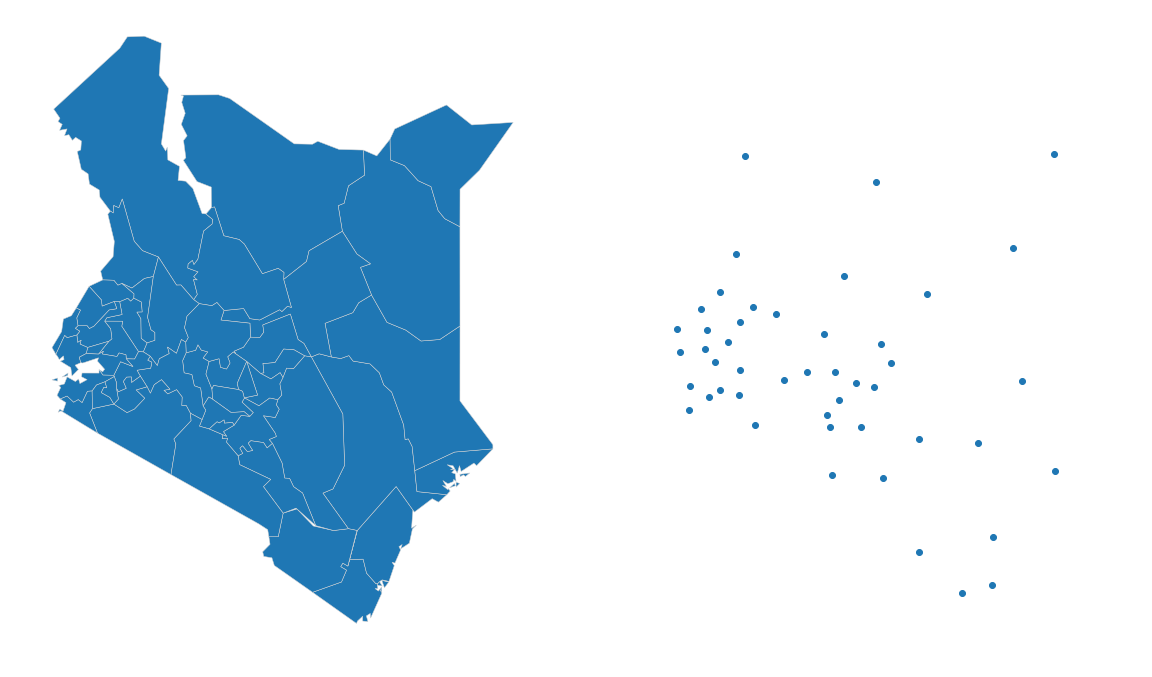

In [5]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax1, linewidth=0.5, edgecolor='lightgrey')

# Plot on axis 2 (right)
ax2.set_axis_off()
admin.set_geometry('geom_centroid').plot(ax=ax2)

plt.show()

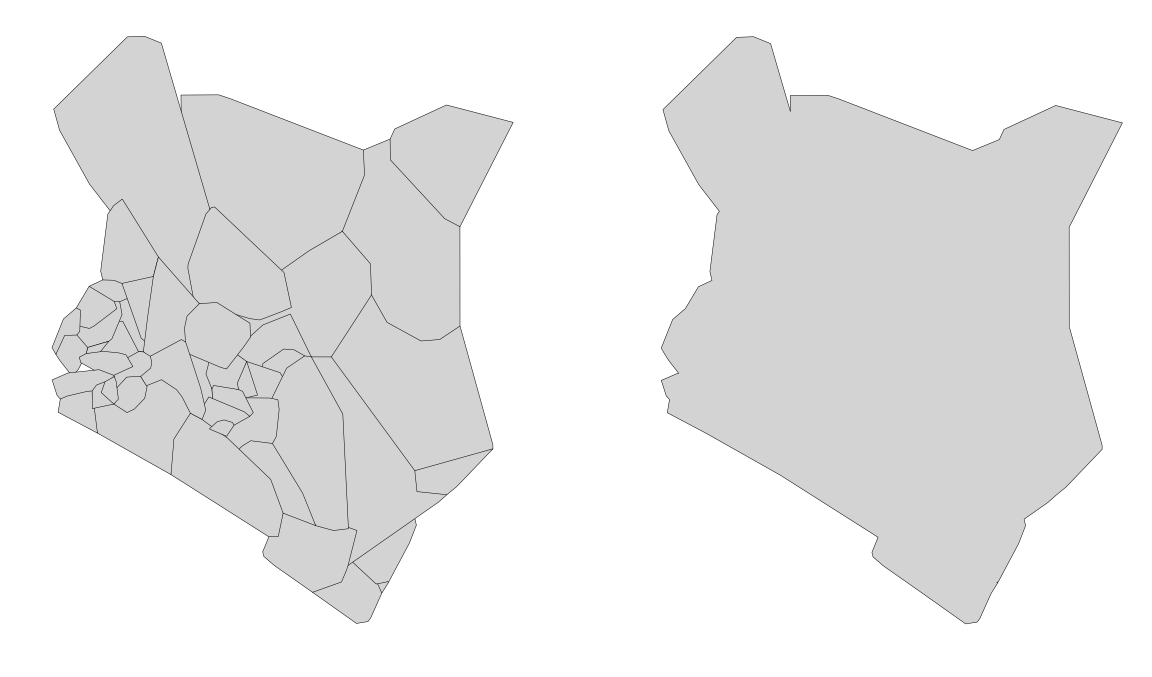

In [6]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_convexhull').plot(ax=ax1, linewidth=0.5, edgecolor='black', color='lightgrey')

# Plot on axis 2 (right)
ax2.set_axis_off()
admin_hulls_dissolved.plot(ax=ax2, linewidth=0.5, edgecolor='black', color='lightgrey')

plt.show()

In [7]:
def round_dict_vals(dictionary, places=10):
    for k, v in dictionary.items():
        dictionary[k] = float(round(dictionary[k], places))
    return dictionary

def get_bounding_coordinates(gpd, round_nums=True):
    tb = gpd.total_bounds
    total_bounds = {'minx': tb[0],
                    'miny': tb[1],
                    'maxx': tb[2],
                    'maxy': tb[3],
                    'rangex': abs(tb[0] - tb[2]),
                    'rangey': abs(tb[1] - tb[3])}
    if round_nums:
        total_bounds = round_dict_vals(total_bounds)
    
    return total_bounds

def build_bounding_polygon(extent, crs):
    BL = (extent['minx'], extent['miny'])
    BR = (extent['maxx'], extent['miny'])
    TR = (extent['maxx'], extent['maxy'])
    TL = (extent['minx'], extent['maxy'])
    corners = [BL, BR, TR, TL]
    rectangle = gpd.GeoDataFrame(pd.DataFrame({'geometry': [Polygon(corners)]}), geometry='geometry', crs=crs)
    
    return rectangle
    
bbox = get_bounding_coordinates(admin.set_geometry('geom_poly'))
bbox_gdf = build_bounding_polygon(bbox, admin.crs)
bbox

{'minx': 33.944107056,
 'miny': -4.676006666,
 'maxx': 41.912158183,
 'maxy': 5.470517919,
 'rangex': 7.968051127,
 'rangey': 10.146524585}

In [49]:
def displace_vertex(x, y, length, angle):
    '''
    calculates new point up to a given distance away
    from original point. All values should be provided
    in meters

    point = (x,y)
    '''
    #The number pi
    PI = 3.1415926535

    #Convert the random angle from degrees to radians
    angle_radian = (angle) * (PI/180)

    #Generate the offset by applying trig formulas (law of cosines) 
    #using the distance as the hypotenuse solving for the other sides
    xOffset = math.sin(angle_radian) * length
    yOffset = math.cos(angle_radian) * length

    #Add the offset to the orginal coordinate
    new_x = x + xOffset
    new_y = y + yOffset

    return (new_x, new_y) 

def build_hexagon(x, y, length, bearing):
    pts = [(x,y)]
    
    for pt in range(0,5):
        x, y = displace_vertex(x, y, length, bearing)
        bearing += 60
        pts.append((x,y))
    hex_poly = Polygon(pts)
    return hex_poly

def tesselate_hexagons_translate(bb, hull, length, flat='up'):
    hexes = []
    
    # flat='up' means flat sides are up and down
    # flat='side' means flat sides are on the sides
    if flat=='up':
        bearing = 30
        next_start_pt_idx = 3
    elif flat=='side':
        bearing = 0
        next_start_pt_idx = 4
    else:
        raise Exception('Acceptable parameters for flat: \'up\' and \'side\'')
    
    hexagon_seed = build_hexagon(bb['minx'], bb['miny'], length, bearing)
    hexagon = hexagon_seed
    
    row=1
    shift = 1
    xy_inside_bbox = True
    while xy_inside_bbox:
        hex_gdf = gpd.GeoDataFrame(pd.DataFrame({'geom_poly': [hexagon]}), geometry='geom_poly')
        centroid = hexagon.centroid

        x_inside = (centroid.x >= bb['minx']) & (centroid.x <= bb['maxx'])
        y_inside = (centroid.y >= bb['miny']) & (centroid.y <= bb['maxy'])
        
        if hull.intersects(centroid):
            hexes += [hex_gdf]
        
        if x_inside and y_inside:
            if flat == 'up':     
                move_x = 3 * length
            elif flat == 'side': 
                move_x = sqrt(3) * length     
            move_y = 0
                
        elif not x_inside and y_inside:
            hexagon = hexagon_seed
            if flat == 'up':
                if row%2 == 0: #Every other row
                    move_y = (sqrt(3) * length * shift)
                    move_x = 0
                    shift+=1 
                else:
                    move_y = ((sqrt(3) * length) * shift) - (0.5 * sqrt(3) * length)
                    move_x = length * 1.5
           
            elif flat == 'side':
                if row%2 == 0: #Every other row
                    move_y = 1.5 * length * row
                    move_x = 0
                else:
                    move_y = 1.5 * length * row
                    move_x = -0.5 * sqrt(3) * length     
            row+=1
            
        else:
            xy_inside_bbox = False
 
        hexagon = translate(hexagon, xoff=move_x, yoff=move_y)

    
    hexes_gdf = gpd.GeoDataFrame(pd.concat(hexes, ignore_index=True, sort=False), crs=hexes[0].crs, geometry='geom_poly')
    hexes_gdf = add_centroid_geom(hexes_gdf)
    return hexes_gdf
    
def iterate_size(adm, bb, flat, iter_factor=1.005):
    length = max(bb['rangex'], bb['rangey']) / (len(adm) * 0.38)
    print(length)
    
    hex_count = len(adm) + 1
    i = 1
    while hex_count > len(adm):
        hexagons = tesselate_hexagons_translate(bb=bbox, 
                                                 hull=admin_hulls_dissolved['geom_convexhull'][1], 
                                                 length=length, 
                                                 flat=flat)
        hex_count = len(hexagons)
        
        print('Iteration: {}  hexagons: {}  length: {}'.format(i, hex_count, length))
        length = length * iter_factor
        i+=1

    return hexagons
        
    

               
               
hexagons_up = iterate_size(admin, bbox, flat='up', iter_factor=1.002)
hexagons_side = iterate_size(admin, bbox, flat='side', iter_factor=1.002)
# hexagons_up =   tesselate_hexagons_translate(bb=bbox, 
#                                              hull=admin_hulls_dissolved['geom_convexhull'][1], 
#                                              length=l, 
#                                              flat='up')
# hexagons_side = tesselate_hexagons_translate(bb=bbox, 
#                                              hull=admin_hulls_dissolved['geom_convexhull'][1], 
#                                              length=l, 
#                                              flat='side')

0.5681144784434491
Iteration: 1  hexagons: 59  length: 0.5681144784434491
Iteration: 2  hexagons: 59  length: 0.569250707400336
Iteration: 3  hexagons: 58  length: 0.5703892088151367
Iteration: 4  hexagons: 58  length: 0.5715299872327669
Iteration: 5  hexagons: 58  length: 0.5726730472072324
Iteration: 6  hexagons: 58  length: 0.5738183933016469
Iteration: 7  hexagons: 58  length: 0.5749660300882502
Iteration: 8  hexagons: 58  length: 0.5761159621484268
Iteration: 9  hexagons: 58  length: 0.5772681940727236
Iteration: 10  hexagons: 58  length: 0.578422730460869
Iteration: 11  hexagons: 58  length: 0.5795795759217908
Iteration: 12  hexagons: 58  length: 0.5807387350736344
Iteration: 13  hexagons: 58  length: 0.5819002125437817
Iteration: 14  hexagons: 58  length: 0.5830640129688692
Iteration: 15  hexagons: 58  length: 0.584230140994807
Iteration: 16  hexagons: 58  length: 0.5853986012767965
Iteration: 17  hexagons: 56  length: 0.5865693984793502
Iteration: 18  hexagons: 56  length: 0.58

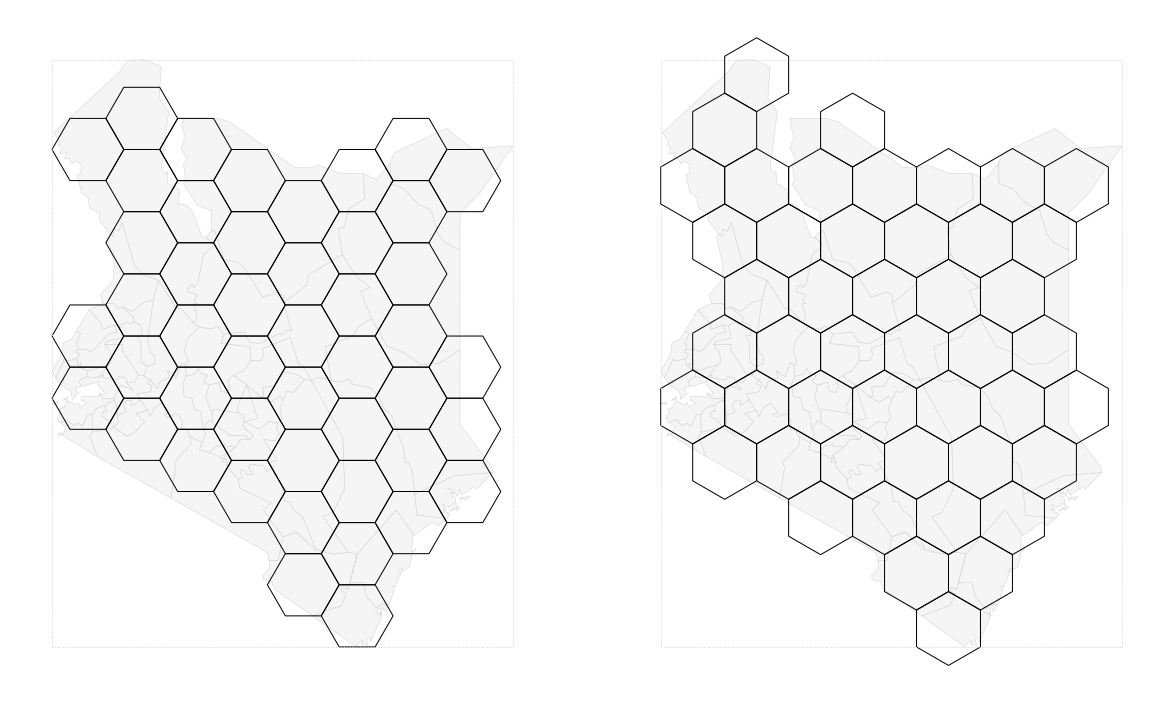

In [55]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax1, linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
hexagons_up.plot(ax=ax1, edgecolor='black', facecolor="none")
bbox_gdf.plot(ax=ax1, facecolor="none", edgecolor='lightgrey', linestyle=':')
#pt.plot(ax=ax1, color='red')

# Plot on axis 2 (left)
ax2.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax2, linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
hexagons_side.plot(ax=ax2, edgecolor='black', facecolor="none")
bbox_gdf.plot(ax=ax2, facecolor="none", edgecolor='lightgrey', linestyle=':')

plt.show()